# Author details and requirements

**Author**: Daniel Hortelano Roig</br>
**Organisation**: University of Oxford, UK</br>
**Contact**: daniel.hortelanoroig@gmail.com</br>
**Date**: December 2024

The [dd2dpy
](https://github.com/dhortela/dd2dpy/) and [pyLabFEA
](https://github.com/AHartmaier/pyLabFEA) packages are required to run this notebook. This notebook is also available on Google Colab via [link](https://colab.research.google.com/drive/1G5okYitqq5SvVCaGI-zf1om0v25BCESr#scrollTo=LAzTcysNxsG4).

# Discrete Dislocation Plasticity (DDP)

In this session we will run a discrete dislocation plasticity (DDP) simulation. This is a simulation method which directly combines dislocation dynamics (DD) and the finite element method (FEM). We will run a simulation which models the bending of a microcantilever.

## Importing simulation code

### Libraries

In [ ]:
# Install and import libraries necessary for this session

import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import pylabfea as fea
import pylabdd as dd

## Helper functions

In [ ]:
def find_element_stresses(element,NX,NY):
  sigdom = np.array([el.sig for el in element])
  sigdom = np.reshape(sigdom,(NX,NY,6))
  sigdom = np.flip(sigdom,axis=1)
  sigdom = np.transpose(sigdom,axes=[1,0,2])
  return sigdom

def sig_xx(X, Y, C, rc):
  hx = np.multiply(X, X)
  hy = np.multiply(Y, Y)
  hh = hx + hy
  return -C*Y*(3.*hx + hy)/(hh*hh + rc)

def sig_yy(X, Y, C, rc):
  hx = np.multiply(X, X)
  hy = np.multiply(Y, Y)
  hh = hx + hy
  return C*Y*(hx - hy)/(hh*hh + rc)

def sig_xy(X, Y, C, rc):
  hx = np.multiply(X, X)
  hy = np.multiply(Y, Y)
  hh = hx + hy
  return C*X*(hx - hy)/(hh*hh + rc)

def calc_stress_at_target(xt, yt, xs, ys, bx, by, C, rc):
  sxx = np.zeros(xt.size)
  syy = np.zeros(xt.size)
  sxy = np.zeros(xt.size)
  for i in range(xs.size):
    sxx += bx[i]*sig_xx(xt-xs[i],yt-ys[i],C,rc)
    sxx += by[i]*sig_yy(xt-xs[i],yt-ys[i],C,rc)
    syy += bx[i]*sig_yy(xt-xs[i],yt-ys[i],C,rc)
    syy += by[i]*sig_xx(xt-xs[i],yt-ys[i],C,rc)
    sxy += bx[i]*sig_xy(xt-xs[i],yt-ys[i],C,rc)
    sxy += by[i]*sig_xy(xt-xs[i],yt-ys[i],C,rc)
  return sxx, syy, sxy

def find_hatstress_at_positions(x,y,w,h,fem,NX,NY):
  sigdom = find_element_stresses(fem.element,NX,NY)
  nx = np.floor(x/w).astype(int)
  ny =  NY - 1 - np.floor(y/h).astype(int)
  nx[nx >= sigdom.shape[1]] = sigdom.shape[1] - 1
  nx[nx < 0] = 0
  ny[ny >= sigdom.shape[0]] = sigdom.shape[0] - 1
  ny[ny < 0] = 0
  sigma = sigdom[ny,nx,:]
  # Extract from Voigt notation
  sxx = sigma[:,0]
  syy = sigma[:,1]
  sxy = sigma[:,5]
  return sxx, syy, sxy

def plot_dislocations(x,y,sp_inc,dx,dy,flag,LX,LY):
  assert x.size == y.size == sp_inc.size == dx.size == dy.size == flag.size
  N = x.size
  qx = np.cos(sp_inc)
  qy = np.sin(sp_inc)
  for i in range(N):
    if flag[i] == 0:
      plt.scatter(x[i],y[i], marker=(3, 0, sp_inc[i]*180/np.pi), s=60, c='blue')
      #plt.quiver(x[i],y[i], qx[i], qy[i], color='green')
      #plt.quiver(x[i],y[i], dx[i], dy[i], color='magenta')
    elif flag[i] == 1:
      plt.scatter(x[i],y[i], marker='o', s=10, c='red')
      #plt.quiver(x[i],y[i], qx[i], qy[i], color='green')
      #plt.quiver(x[i],y[i], dx[i], dy[i], color='magenta')
  ax = plt.gca()
  ax.set_xlabel(r'x ($\mu$m)',fontsize=14)
  ax.set_ylabel(r'y ($\mu$m)',fontsize=14)
  ax.set_xlim(0, LX)
  ax.set_ylim(0, LY)
  ax.set_aspect('equal')

Note that in the following session we will combine two simulation methods which each use different units.
>In DD simulations, the units are:
>* Stress: MPa ($10^6$ Pascals)
>* Length: micrometres ($10^{-6}$ metres)
>* Time: microseconds ($10^{-6}$ seconds)
>
>While in FEM simulations, the units are:
>* Stress: MPa ($10^6$ Pascals)
>* Length: milimetres ($10^{-3}$ metres)
>* Time: microseconds ($10^{-6}$ seconds)

## Tensile test of Zirconium metal

### Setting up the DD and FEM parameters

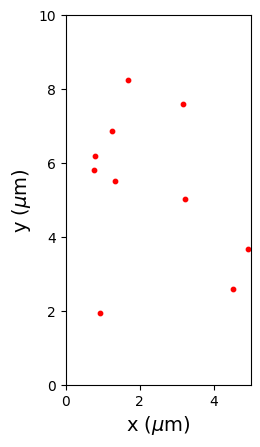

In [ ]:
warnings.filterwarnings("ignore")

# Fixed seed
np.random.seed(90)

# Define material and DD parameters for Zirconium

mu = 37.1e3                 # Shear modulus
nu = 0.32                   # Poisson ratio
E = 2*mu*(1+nu)             # Young's modulus
b0 = 3.233e-4               # Burgers vector norm
C = mu*b0/(2*np.pi*(1.-nu)) # Constant for dislocation stress field

# Set mobility law used for dislocation motion:
moblaw = 'viscous' # 'viscous' or 'powerlaw'

# Specify finite domain where dislocations are allowed to exit AND is coupled to FEM:
bc = 'finiteFEM'

# Domain boundaries
LX = 5.
LY = 10.
LZ = LY # For FEM we must specify a DEPTH as well

dt0 = 0.02 # Initial time-step
dmax = 0.2 # Max distance any dislocation is allowed to traverse
dmob = 1. # Mobility coefficient: relation between dislocation force and velocity
ctau = 5 # Frank-Read source activation stress

# The following configuration creates Ntot Frank-Read sources
# and 0 mobile dislocations:
Ntot = 10
Nmob = 0

# Orientation angle:
spi1 = np.pi/4

# Dislocation positions:
xpos = LX*np.random.rand(Ntot)
ypos = LY*np.random.rand(Ntot)

# Tolerance parameters:
rc = 1.e-2 # Cutoff parameter for forces on the surface
cutoff = 1.e-7 # Cutoff parameter for stresses on dislocations

# Define FEM parameters

NX = 5
NY = 10
w = LX/NX
h = LY/NY
d = LZ

# DD network creation

dsl = dd.Dislocations(Nd=Ntot, Nm=Nmob, spi1=spi1, \
                      C=C, b0=b0, dmob=dmob, f0=10., m=7, dmax=dmax, \
                      xpos=xpos, ypos=ypos, \
                      LX=LX, LY=LY, bc=bc, dt0=dt0, ctau=ctau, tnuc=10.e-3, postdt=True, \
                      cutoff=cutoff)

plot_dislocations(dsl.xpos,dsl.ypos,dsl.sp_inc,dsl.dx,dsl.dy,dsl.flag,LX,LY)

### Setup boundaries

In [ ]:
# FEM construction

fem = fea.Model(dim=2,planestress=True)
fem.geom(sect=1, LX=1.e-3*LX, LY=1.e-3*LY, LZ = 1.e-3*LZ)
mat = fea.Material()              # create element of class Material
mat.elasticity(E=E, nu=nu)  # assign isotropic elastic properties
fem.assign([mat])
fem.mesh(NX=NX,NY=NY,SF=1)
#d = fem.thick*1.e3
#d = LY

nodelist = list(range(fem.Nnode))
nodepos = np.reshape(fem.npos,(fem.Nnode,2))*1.e3
#noouterpos = nodepos[np.array(nodelist) != np.array(fem.noinner),:] # Boundary node positions
noouterpos = nodepos[~np.isin(nodelist,fem.noinner),:] # Boundary node positions

noouter = np.setdiff1d(nodelist,fem.noinner)

# Surface areas
surfareas = np.zeros(noouter.size)
# Faces
topface = np.isin(noouter,fem.notop)&~np.isin(noouter,fem.noleft)&~np.isin(noouter,fem.noright)
surfareas[topface] = w*d
botface = np.isin(noouter,fem.nobot)&~np.isin(noouter,fem.noleft)&~np.isin(noouter,fem.noright)
surfareas[botface] = w*d
leftface = np.isin(noouter,fem.noleft)&~np.isin(noouter,fem.notop)&~np.isin(noouter,fem.nobot)
surfareas[leftface] = h*d
rightface = np.isin(noouter,fem.noright)&~np.isin(noouter,fem.notop)&~np.isin(noouter,fem.nobot)
surfareas[rightface] = h*d
# Corners
topleft = np.isin(noouter,fem.notop)&np.isin(noouter,fem.noleft)
surfareas[topleft] = (h/2 + w/2)*d
topright = np.isin(noouter,fem.notop)&np.isin(noouter,fem.noright)
surfareas[topright] = (h/2 + w/2)*d
botleft = np.isin(noouter,fem.nobot)&np.isin(noouter,fem.noleft)
surfareas[botleft] = (h/2 + w/2)*d
botright = np.isin(noouter,fem.nobot)&np.isin(noouter,fem.noright)
surfareas[botright] = (h/2 + w/2)*d

# Surface normals
normals = np.zeros((noouter.size,2))
top = np.isin(noouter,fem.notop)
normals[top,:] = np.array([0, 1]) # 4th priority
bot = np.isin(noouter,fem.nobot)
normals[bot,:] = np.array([0, -1]) # 3rd priority
left = np.isin(noouter,fem.noleft)
normals[left,:] = np.array([-1, 0]) # 2nd priority
right = np.isin(noouter,fem.noright)
normals[right,:] = np.array([1, 0]) # 1st priority

# Initialise FEM structures

f_tilda = np.zeros((fem.Nnode,2))
f_hat = np.zeros((fem.Nnode,2))

# Initialise variables

epl = 0. # plastic strain
ubar_np = np.array([]) # for postprocessing
fbar_np = np.array([])
t = np.array([])
epl_np = np.array([])
rho_m_np = np.array([])
ic = 0 # iteration
icp = 0 # plot iteration
dt = dt0

### Setup strain parameters and surface sets

You have access to the following surface sets:

$\texttt{fem.noright}$

$\texttt{fem.noleft}$

$\texttt{fem.notop}$

$\texttt{fem.nobot}$


In [ ]:
# Set strain parameters

u_dot = 1.e-4 # Displacement rate
globuniformrss = 0.
totalSimTime = 7.25e0
simTime = 0.

# Define sets of surface nodes

gammau = fem.noleft
#gammamixed = list(set.intersection(set(fem.noright), set(fem.notop)))
gammamixed = fem.noright
gammat = np.setdiff1d(noouter,gammau+gammamixed).tolist()

gft = gammat + gammamixed
igft = np.isin(noouter,gft)

### Run simulation

2900 : ubar = 7.24955E-04 | fbar = 1.19029E+03  | Total time = 7.25010E+00 | Nmob = 785
End of simulation.


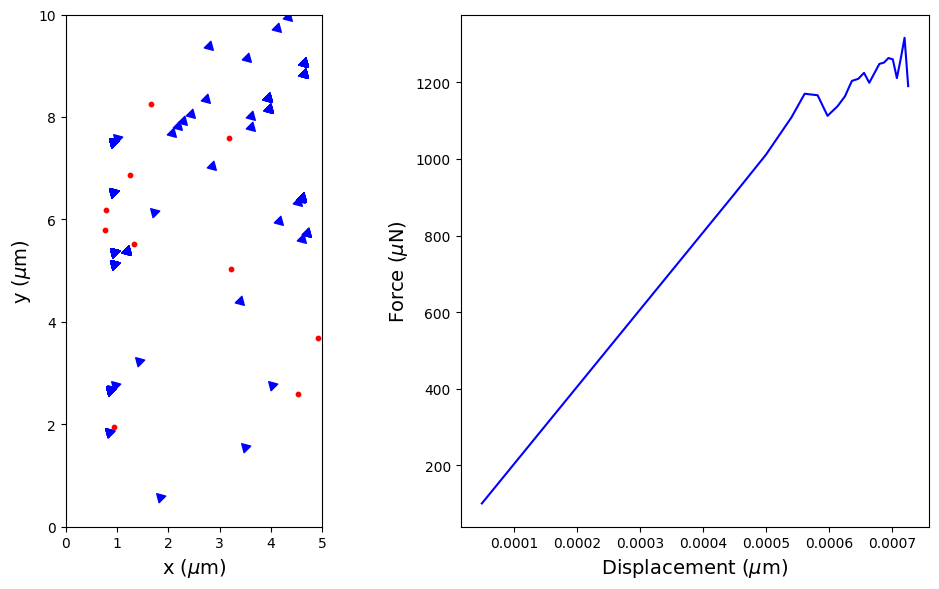

In [ ]:
saveFreq = 100 # frequency of data storage
plotFreq  = 100 # frequency of plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Simulation loop

while simTime < totalSimTime:

  if dsl.Ntot <= 0:
    break

  sxx, syy, sxy = calc_stress_at_target(nodepos[gft,0], nodepos[gft,1], \
                        dsl.xpos[dsl.flag == 0], dsl.ypos[dsl.flag == 0], \
                        dsl.bx[dsl.flag == 0], dsl.by[dsl.flag == 0], \
                        C, rc)
  # Tractions
  Tx = sxx * normals[igft, 0] + sxy * normals[igft, 1]
  Ty = sxy * normals[igft, 0] + syy * normals[igft, 1]
  ATx = surfareas[igft] * Tx;
  ATy = surfareas[igft] * Ty;
  f_tilda[gft,0] = ATx;
  f_tilda[gft,1] = ATy;
  f_hat = -f_tilda

  ubar = u_dot * simTime

  # Displacement BCs
  fem.bcleft(0., 'disp', 'x')
  fem.bcleft(0., 'disp', 'y')
  fem.bcright(ubar*1.e-3, 'disp', 'x')
  #fem.bcright(0., 'disp', 'x')
  fem.bcright(0., 'force', 'y')
  fem.bctop(0, 'force','x')
  fem.bctop(0, 'force','y')
  fem.bcbot(0., 'force','x')
  fem.bcbot(0., 'force','y')
  # Force BCs
  for i in range(len(gammat)):
    fem.bcnode(gammat[i], f_hat[gammat[i],0]*1.e-3**2, 'force', 'x')
    fem.bcnode(gammat[i], f_hat[gammat[i],1]*1.e-3**2, 'force', 'y')
  for i in range(len(gammamixed)):
    fem.bcnode(gammamixed[i], f_hat[gammamixed[i],1]*1.e-3**2, 'force', 'y')
    #fem.bcnode(gammamixed[i], ubar*1.e-3, 'disp', 'x')

  fem.solve()
  rhat = np.reshape(fem.f*1.e3**2,(fem.Nnode,2))
  fbar = np.sum(rhat[gammamixed,0])

  hatsxx, hatsyy, hatsxy = find_hatstress_at_positions(dsl.xpos,dsl.ypos,w,h,fem,NX,NY)

  # Time integration
  fsp, dt = dsl.move_disl(globuniformrss, moblaw, dt, \
                          sigextxx=hatsxx, sigextyy=hatsyy, sigextxy=hatsxy)

  # This should print if any dislocation forces are bad:
  if np.any(abs(fsp) == dsl.cutoff):
    print(fsp[fsp==dsl.cutoff].size)

  simTime += dt
  ic += 1

  if ic % saveFreq == 0:

    ubar_np = np.append(ubar_np,ubar)
    fbar_np = np.append(fbar_np,fbar)
    rho_m_np = np.append(rho_m_np, dsl.rho_m)

  if ic % plotFreq == 0:

    icp = ic

    display.clear_output(wait=True)

    plt.sca(ax1)
    ax1.cla()
    plot_dislocations(dsl.xpos,dsl.ypos,dsl.sp_inc,dsl.dx,dsl.dy,dsl.flag,LX,LY)

    plt.sca(ax2)
    ax2.plot(abs(ubar_np),fbar_np,'b')
    ax2.set_xlabel(r'Displacement ($\mu$m)',fontsize=14)
    ax2.set_ylabel(r'Force ($\mu$N)',fontsize=14)

    fig.tight_layout()

    display.display(plt.gcf())

    print(ic,': ubar =', '%.5E' % ubar,'| fbar =','%.5E' % fbar,' | Total time =','%.5E' % simTime,'| Nmob =','%d' % dsl.Nmob)

display.clear_output(wait=True)
plt.sca(ax1)
ax1.cla()
plot_dislocations(dsl.xpos,dsl.ypos,dsl.sp_inc,dsl.dx,dsl.dy,dsl.flag,LX,LY)

plt.sca(ax2)
ax2.plot(abs(ubar_np),fbar_np,'b')
ax2.set_xlabel(r'Displacement ($\mu$m)',fontsize=14)
ax2.set_ylabel(r'Force ($\mu$N)',fontsize=14)

fig.tight_layout()

print(ic,': ubar =', '%.5E' % ubar,'| fbar =','%.5E' % fbar,' | Total time =','%.5E' % simTime,'| Nmob =','%d' % dsl.Nmob)
print('End of simulation.')

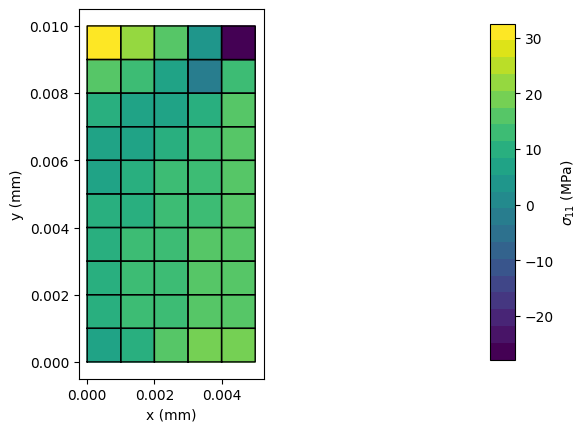

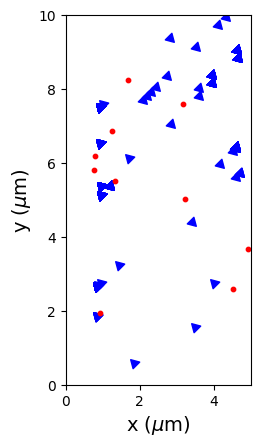

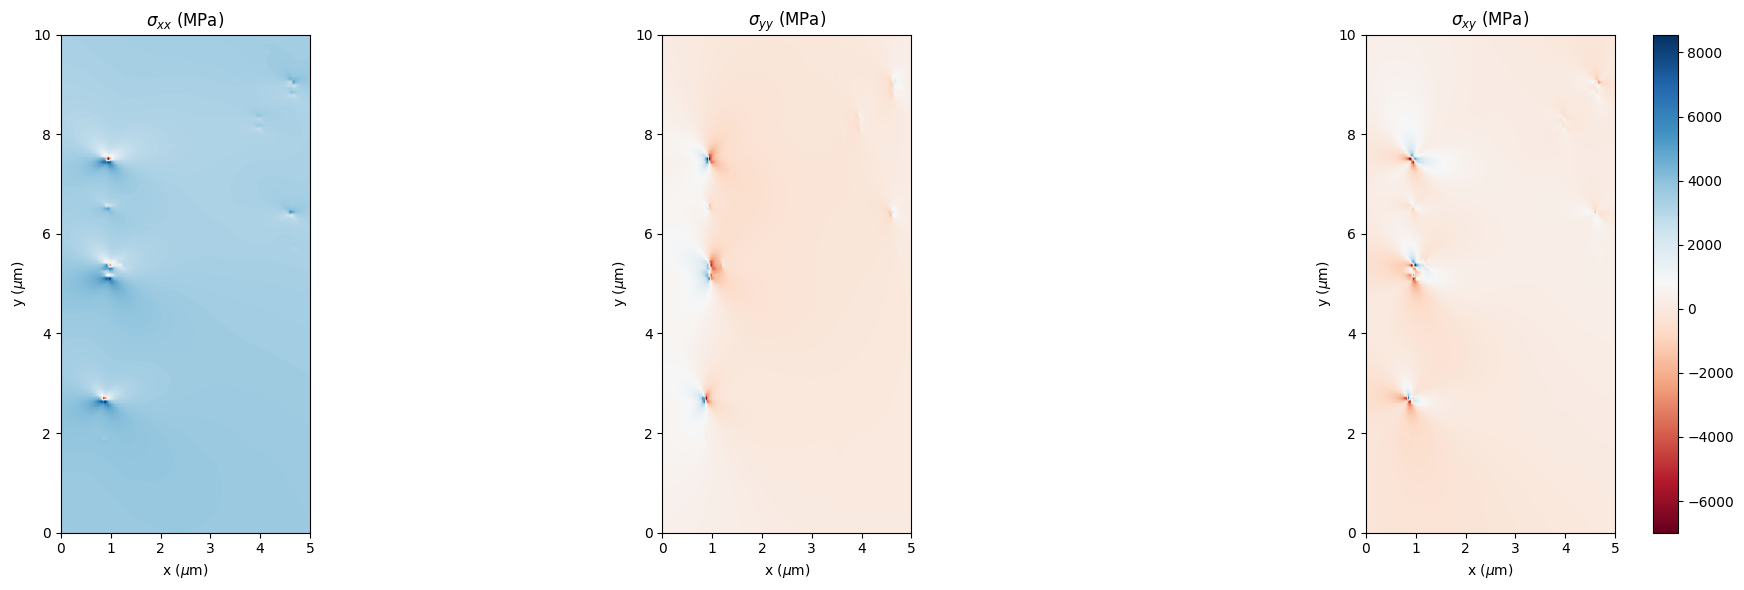

In [ ]:
fem.plot('stress1', mag=1, shownodes=False)
plot_dislocations(dsl.xpos,dsl.ypos,dsl.sp_inc,dsl.dx,dsl.dy,dsl.flag,LX,LY)
dsl.plot_stress_mob()

# Challenge


Try to set up a cantilever bending code instead of a tensile test. Copy and paste as much of the previous code as possible.